In [1]:
import pandas as pd
import numpy as np
import seaborn as sns 
import math
import matplotlib.pyplot as plt 
import os 
from sklearn.linear_model import LinearRegression
from statistics import mean
from sklearn import preprocessing as prep

# data_path = "D:\\Kaggle\\PulmonaryFibrosisProgression"


In [2]:
train = pd.read_csv("traindata.csv")
test = pd.read_csv("testdata.csv")
submit = pd.read_csv("sample_submission.csv")


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1549 entries, 0 to 1548
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Patient        1549 non-null   object 
 1   Weeks          1549 non-null   int64  
 2   FVC            1549 non-null   int64  
 3   Percent        1549 non-null   float64
 4   Age            1549 non-null   int64  
 5   Sex            1549 non-null   object 
 6   SmokingStatus  1549 non-null   object 
dtypes: float64(1), int64(3), object(3)
memory usage: 84.8+ KB


Training set has <b>1549</b> enteries<br>
It has <b>176</b> unique 

In [4]:
submit['Patient'] = submit['Patient_Week'].apply(lambda x :x.split('_')[0])
submit['Weeks'] = submit['Patient_Week'].apply(lambda x :x.split('_')[-1])

submit = submit.drop('FVC', axis=1)
submit = submit[['Patient', 'Weeks', 'Confidence', 'Patient_Week']]
submit = submit.merge(test.drop('Weeks',axis=1), on='Patient')  

#730 is the 5 records for 146 patients

In [5]:
submit = submit[['Patient', 'Weeks','FVC','Percent', 'Age', 'Sex','SmokingStatus' ,'Confidence', 'Patient_Week']] #Reordering


In [6]:
#Adding indicator for dataset identification

train["Dataset"] = 'Train'
test["Dataset"] = 'Test'
submit["Dataset"] = 'Submission'

In [7]:
train.iloc[train.duplicated(['Patient', 'Weeks'], keep=False).sort_values(ascending=False).head(14).index].sort_values(by=['Patient'])

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,Dataset
167,ID00048637202185016727717,9,1477,64.514720,70,Female,Never smoked,Train
166,ID00048637202185016727717,9,1375,60.059404,70,Female,Never smoked,Train
227,ID00068637202190879923934,11,2827,83.609369,73,Male,Ex-smoker,Train
226,ID00068637202190879923934,11,2794,82.633385,73,Male,Ex-smoker,Train
306,ID00089637202204675567570,7,2478,57.967624,63,Male,Never smoked,Train
307,ID00089637202204675567570,7,2539,59.394592,63,Male,Never smoked,Train
465,ID00125637202218590429387,8,2349,53.757781,65,Male,Never smoked,Train
466,ID00125637202218590429387,8,2584,59.135848,65,Male,Never smoked,Train
750,ID00199637202248141386743,5,2672,64.728682,62,Male,Ex-smoker,Train
751,ID00199637202248141386743,5,2683,64.995155,62,Male,Ex-smoker,Train


After checking dataset for duplicates it was found that there are seven patients who recorded more than one(here two) FVC readings for the same week. To establish consistency the average of readings was taken and then added back to the database for both <b>FVC</b> and <b>Percent</b>.

In [8]:
temp = train.groupby(['Patient', 'Weeks'], as_index=False)['FVC','Percent'].mean()

train = train.drop_duplicates(['Patient','Weeks']).drop(['FVC','Percent'],axis=1).merge(temp, on=['Patient', 'Weeks'])
len(train['Patient'].unique())

176

In [29]:
train.describe()

,Weeks,Age,FVC,Percent
count,1542.000000,1542.000000,1542.000000,1542.000000
mean,31.931907,67.192607,2691.263294,77.710239
std,23.229854,7.068397,833.927148,19.847108
min,-5.000000,49.000000,827.000000,28.877577
25%,12.000000,63.000000,2108.250000,62.840249
50%,28.000000,68.000000,2642.000000,75.677774
75%,47.000000,72.000000,3175.000000,88.650583
max,133.000000,88.000000,6399.000000,153.145378


In [23]:
 train['Required'] = train['FVC'] / (train['Percent'] / 100)


,Patient,Weeks,Age,Sex,SmokingStatus,Dataset,FVC,Percent,Required
0,ID00007637202177411956430,-4,79,Male,Ex-smoker,Train,2315.0,58.253649,3974.0
1,ID00007637202177411956430,5,79,Male,Ex-smoker,Train,2214.0,55.712129,3974.0
2,ID00007637202177411956430,7,79,Male,Ex-smoker,Train,2061.0,51.862104,3974.0
3,ID00007637202177411956430,9,79,Male,Ex-smoker,Train,2144.0,53.950679,3974.0
4,ID00007637202177411956430,11,79,Male,Ex-smoker,Train,2069.0,52.063412,3974.0
...,...,...,...,...,...,...,...,...,...
1537,ID00426637202313170790466,13,73,Male,Never smoked,Train,2712.0,66.594637,4072.4
1538,ID00426637202313170790466,19,73,Male,Never smoked,Train,2978.0,73.126412,4072.4
1539,ID00426637202313170790466,31,73,Male,Never smoked,Train,2908.0,71.407524,4072.4
1540,ID00426637202313170790466,43,73,Male,Never smoked,Train,2975.0,73.052745,4072.4


In [37]:
train['Required'] = train['Required'].round(decimals = 2)

In [53]:
def estimate_height(row, sex):
    # if (sex == 'Male'):
    #     return (-74.7) / (np.log(row.Required /1000) - 0.544 * np.log(row.Age) + 0.0151 * row.Age - 5.48)
    # else:
    #     return None
    return ((row.Required /1000)  + 0.026 * row.Age + 2.89) / 0.0443


train['Height'] = train.apply(lambda x : estimate_height(x, x.Sex),axis=1)
train.drop_duplicates(['Patient']).head()

,Patient,Weeks,Age,Sex,SmokingStatus,Dataset,FVC,Percent,Required,Height
0,ID00007637202177411956430,-4,79,Male,Ex-smoker,Train,2315.0,58.253649,3974.0,201.309255
9,ID00009637202177434476278,8,69,Male,Ex-smoker,Train,3660.0,85.282878,4291.6,202.609481
18,ID00010637202177584971671,0,60,Male,Ex-smoker,Train,3523.0,94.724672,3719.2,184.406321
27,ID00011637202177653955184,6,72,Male,Ex-smoker,Train,3326.0,85.987590,3868.0,194.808126
36,ID00012637202177665765362,33,65,Male,Never smoked,Train,3418.0,93.726006,3646.8,185.706546


## Encoding Training & Testing Data
### Categorical encoding the Smoking Status
Smoking Status is labelled as follows:<br>
0  <-- Currently Smoking <br>
1  <-- Ex-Smoker <br>
2  <-- Never Smoked  <br>

Sex is label encoded and then one hot encoded. <br>
1 = Male  0 = Female


In [ ]:
labelEnconder = prep.LabelEncoder()
oneHotEncoder = prep.OneHotEncoder()

train['SmokingStatus'] = labelEnconder.fit_transform(train['SmokingStatus'])
train.head()


In [ ]:
data_set.head()

In [ ]:
# integerEncd = pd.get_dummies(data_set['Sex'], prefix="Sex")

# data_set = data_set.join(integerEncd)
data_set = data_set.drop('Sex', axis=1)


In [ ]:
patient_db = pd.DataFrame()

patient_db = data_set.drop_duplicates(subset = 'Patient').drop(['FVC', 'Percent' ], axis=1)
print("Number of unique patient data: ", len(patient_db))

patient_db.head()

In [ ]:
#Checking for null enteries in database
data_set[data_set.isnull().any(axis=1)].head()

In [ ]:
#Grouping Data by Patient ID for easy sorting

grp = data_set.copy().groupby(['Patient'])

patient_db["test_count"] = grp["FVC"].count().reset_index()["FVC"]

# patient_db[patient_db['test_count'].isnull()]  #Checking if counting is done properly
patient_db

In [ ]:
print(patient_db.describe())

## Plot Patient Data <br>


In [ ]:
# sns.set(rc={'figure.figsize':(20,10 )})

# f, ax = plt.subplots(figsize = [20,10])

def best_fit_slope(xs,ys):
    m = (((mean(xs)*mean(ys)) - mean(xs*ys)) /
         ((mean(xs)**2) - mean(xs**2)))
    return m

bfl = []

for id, d in grp:
    bfl.append(best_fit_slope(d.Weeks, d.FVC))

patient_db["rate_of_decent"] = bfl

patient_db.head()
patient_db.describe()
    # ax = sns.regplot (x="Weeks", y="FVC", data = d)


### Histogram to denote the density of available records per patient

<AxesSubplot:xlabel='Weeks', ylabel='Density'>

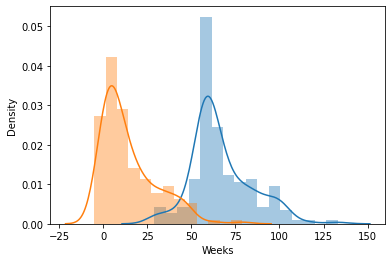

In [20]:
sns.distplot(train.groupby('Patient')['Weeks'].max())  
sns.distplot(train.groupby('Patient')['Weeks'].min())  

### Identifying the average deviation of first FVC reading from the date of scan

In [ ]:
ax = sns.barplot(x='Weeks',y='Patient', data=patient_db.sort_values('Weeks'), palette="rocket")
ax.set(yticks= [])


In [ ]:
patient_db

In [21]:
from scipy.stats import pearsonr
# from numpy import cov

corr, _ = pearsonr(train['Age'],train[' '])
print('Pearsons correlation: %.3f' % corr)

KeyError: 'Required'